<p style="text-align: center;"><font size="8"><b>Optimization</b></font><br>

A common task in science and engineering is to find the minimum (or maximum) of a function. For example we may want to find the shape of a wing that minimizes drag. Problems like these are called *optimization* problems. 

The formal definition of a minimization problem is:
$$\text{find } \mathbf{x} \text{ such that } f(\mathbf{x}) \text{ is as small as it can be.}$$
That is for all $\mathbf{y}$, $f(\mathbf{y}) \geq f(\mathbf{x})$.

For example the minimum of $f(x) = 1 + x^2$ is $x = 0$. 

## Global vs. Local Minimuma

An important concept in optimization is that of global minimum vs. local minimuma. 

## Steepest Descent

One method to compute a local minimum is known as the method of steepest descent. This method uses derivative information to iterate to the local mimimum of a function $f(x)$. Loosely speaking, starting from a point $x_0$, we take a step in the direction that the function is decreasing. The step size is somehow related to the size of the dirivative. If the derivative is large we take a large step, if it is small we take a small step.

Starting from a point $x_0$, the sequence of iterates:
$$ x_{k+1} = x_k - \gamma_k f'(x_k)$$
converges to the local minimum $x^*$, provided $\gamma^k$ satisfies certain conditions. 

How do we choose $\gamma_k$? 

There are several methods we can use. We will use a backtracking line search. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def backtrack_search(f, df, p, x, gamma = 10, c = 0.5, max_it = 100):
    it_count = 0
    while f(x + gamma*p) > f(x) + 0.5*gamma*np.dot(p,df(x)) and it_count < max_it:
        it_count += 1
        gamma = c*gamma

    return gamma

In [3]:
f = lambda x: x**3 - 2*x**2 + 2
df = lambda x: 3*x**2 - 4*x
x = 2
p = -df(x)/np.linalg.norm(df(x))
gamma = backtrack_search(f, df, p, x)

In [4]:
def steepest_descent(f, df, x0, gamma0 = 10, max_it = 1000, tol = 1e-6):
    
    # we'll keep track of our steps here, this is not really necessary
    x = []
    gamma = []
    m = []
    
    x.append(x0)  
    m.append(df(x0))
    
    it_count = 0
    
    while np.linalg.norm(m[-1]) > tol and it_count < max_it:
        it_count += 1
        xk = x[-1]
        
        # compute search direction
        p = -df(xk)/np.linalg.norm(df(xk))

        # compute step size
        gamma.append(backtrack_search(f, df, p, xk)) 
        
        # compute new approximation
        x.append(xk + gamma[-1]*p)
        m.append(df(x[-1]))
     
    return x, gamma, m

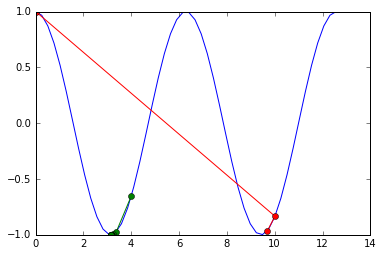

In [5]:
f = lambda x: np.cos(x)
df = lambda x: -np.sin(x)

x1, gamma1, m1 = steepest_descent(f, df, 0.01)
x2, gamma2, m2 = steepest_descent(f, df, 4)

plt.plot(np.linspace(0,4*np.pi), f(np.linspace(0,4*np.pi)), 'b')
plt.plot(x1[0:3], f(np.array(x1[0:3])), '-ro')
plt.plot(x2, f(np.array(x2)), '-go')

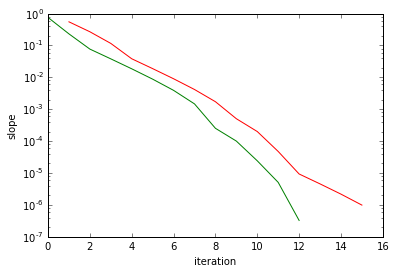

In [6]:
plt.semilogy(m1, 'r')
plt.semilogy(m2, 'g')
plt.xlabel("iteration")
plt.ylabel("slope")

## Higher Dimensions

In higher dimensions the derivative becomes a gradient. The method of steepest descent now looks like:

$$ \mathbf{x}_{k+1} =\mathbf{x}_k - \gamma_k \nabla f(\mathbf{x}_k). $$ 



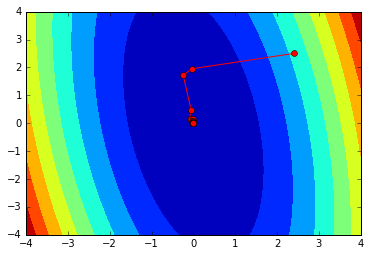

In [24]:
f = lambda x: 8*x[0]**2 + x[1]**2 + 2*x[0]*x[1]
df = lambda x: np.array([16*x[0] + 2*x[1],2*x[1] + 2*x[0]])

a = np.array([2.4,2.5])
b = np.array([-2.8,-3.8])

x1, gamma1, grad1 = steepest_descent(f, df, a)

x = np.linspace(-4,4)
y = np.linspace(-4,4)
X, Y = np.meshgrid(x,y)
plt.contourf(X,Y,f(np.array([X,Y])),10)

xa = np.array(x1)
plt.plot(xa[:,0],xa[:,1], '-ro')

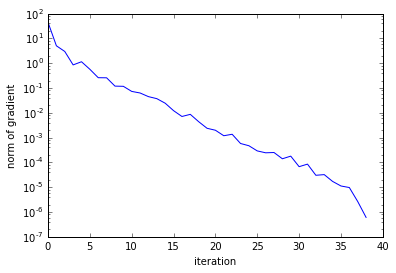

In [8]:
plt.semilogy(np.linalg.norm(np.array(grad1), axis=1))
plt.xlabel("iteration")
plt.ylabel("norm of gradient")

## Simulated Annealing

Another method for optimization is the stochastic simulated annealing. Unlike gradient based methods, this method does not require any gradient information. It can be used to find the global minimum.

The basic idea behind simulated annealing is to take a step in a random direction starting from a point $x_0$ to a point $x_1$. If the objective function decreases, we'll accept the step with probability $P_1$, set $x_0$ to $x_1$ and repeat the process. Otherwise we'll reject the step and try another step from $x_0$. 

If the function value increases, we may still accept this step with probability $P_2$

Thus we will be hopefully in general decreasing the function, however we may increase the function occasionally. This prevents us from becoming stuck in a local minimum.

In [9]:
def temperature(k, T0):
    return T0*0.9**k

In [10]:
def accept(T, df):
    p_accept = np.exp(-df/T)
    return p_accept > np.random.rand()

In [11]:
def annealing_step(x, T):
    direction = np.random.randint(0,2)
    if direction == 0: # step to the right
        x_tmp = x + T
    else: # step to the left
        x_tmp = x - T
        
    return x_tmp

In [20]:
def simulated_annealing(f, x0, T0 = 30, max_it = 1000, tol = 1e-5):
    
    k = 0
    diff = 2*tol
    
    x = []
    fx = []
    
    x.append(x0)
    fx.append(f(x0))
    min_so_far = fx[-1]
    x_best = x[-1]
    restarts = 0
    
    while diff > tol and k < max_it:
        
        k = k + 1
        
        # update temperature
        T = temperature(k, T0)
            
        # take step
        x_tmp = annealing_step(x[-1], T)      
 
        # compute difference in objective function
        df = f(x_tmp) - f(x[-1])
        
        # decide whether to accept or reject the step
        if df < 0: # accept step
            x.append(x_tmp)
            fx.append(f(x_tmp))
        else: # accept with probability P
            if accept(T, df):
                x.append(x_tmp)
                fx.append(f(x_tmp))
                
        if fx[-1] < min_so_far:
            min_so_far = fx[-1]
            x_best = x[-1]
       
        # every 20 steps go back to the best x so far
        if k % 20 == 0:
            restarts += 1
            x[-1] = x_best
            T = T0/restarts**2
            
        if len(x) > 1:
            diff = abs(x[-2] - x[-1])
                
    return x, fx

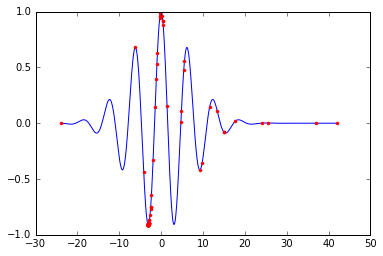

In [21]:
f = lambda x: np.cos(x)*np.exp(-x**2/100)

xa, fx = simulated_annealing(f, 15)
x= np.linspace(min(xa), max(xa), 1000)

plt.plot(x, f(x))
plt.plot(xa, f(np.array(xa)), 'r.')

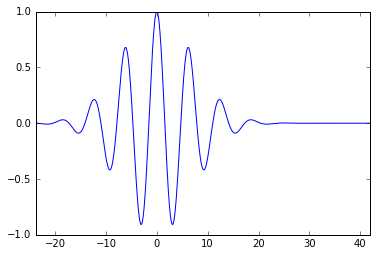

In [22]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import matplotlib.pyplot as plt

# configure matplotlib animations to display in notebook
rc('animation', html='html5')

# create an empty figure and axis
fig, ax = plt.subplots()

# set axis limits, these will not change during the animation
ax.set_xlim((min(xa),max(xa)))
ax.set_ylim((-1,1))

# plot f(x), this will be on every frame
x= np.linspace(min(xa), max(xa), 1000)
plt.plot(x, f(x))

# add blank line for annealing data, we will edit this every frame
line_annealing, = ax.plot([],[],'-r')

# at this point since we matplotlib is in inline mode, it prints a blank figure

In [23]:

# define initialization function
def init():
    line_annealing.set_data([xa[0], xa[0]], [-2, 2])

# define update function
def update(k):
    # may want to print k here
    line_annealing.set_data([xa[k], xa[k]], [-2, 2])

anim = FuncAnimation(fig, update, init_func=init, frames=range(0,len(xa)), interval=100)
anim